# A *Very Rough* Analysis of #talkpay Tweets

The data used in this analysis were fetched from Twitter using [twick](http://github.com/jsvine/twick), searching for "#talkpay -filter:retweets" (to exclude retweets). The data run through approximately noon Pacific Time on Saturday, May 2. A raw CSV of the tweets can be found [here](https://github.com/buzzfeednews/2015-05-talkpay-tweets/master/data/talkpay-tweets.csv).

A few important caveats about the data and analysis:

- What people tweet is *not* necessarily what they earn. In this analysis, we don't distinguish between what people say they make and what they say, for example, their bosses make.


- Not everything that *looks like a salary* is one. In the analysis below, we're counting things that look like a salary, e.g., "50k", "\$20k", "\$350,000", "\$15,500." The analysis throws out "401k"s, on the assumption that it represents a retirement account, rather than a salary figure. But there may be other "false positives" — and plenty of "false negatives," e.g., "I make twenty grand" — that we're missing.


- The analysis of the distribution of salaries uses the *maximum* salary-looking figure from each tweet, based on the observation that many tweets narrated a progression of salaries over a series of jobs/positions.


- The distribution analysis also ignores salaries reported in € and £. 

In [1]:
%matplotlib inline
import pandas as pd
import re

In [2]:
salary_pat = re.compile(r"[\$£€][\d\.]{1,3}[,Kk]\d{0,3}|\d{1,3}k")
currency_pat = re.compile(r"[\$£€]")
link_pat = re.compile(r"http[^ ]+")

In [3]:
def is_likely_salary(text):
    if "401k" in text.lower(): return False
    if int(re.sub(r"[^\d]", "", text)) == 0: return False
    return True

In [4]:
def is_likely_usd(text):
    if text[0] in [ "£", "€" ]: return False
    return True

In [5]:
def extract_salary_text(text):
    without_links = re.sub(link_pat, "", text)
    found = list(filter(is_likely_salary, re.findall(salary_pat, without_links)))
    if len(found): return found
    else: return None

In [6]:
def intify_salary(string):
    x = re.sub(currency_pat, "", string.lower())
    if "k" in x:
        return int(float(x[:-1]) * 1000)
    else:
        return int(x.replace(",", ""))

In [7]:
tweets = pd.read_csv("../data/talkpay.csv", parse_dates=["created_at"])

In [8]:
print("Tweets collected: {0:,}".format(len(tweets)))

Tweets collected: 9,604


In [9]:
tweets["all_salaries"] = tweets["text"].apply(extract_salary_text)
tweets["usd_salaries"] = tweets["all_salaries"]\
    .apply(lambda x: list(filter(is_likely_usd, x)) if x else None)
tweets["usd_salary_ints"] = tweets["usd_salaries"]\
    .apply(lambda x: list(map(intify_salary, x)) if x else None)

In [10]:
salary_tweets = tweets[
    tweets["all_salaries"].apply(lambda x: type(x) == list)
].copy()

In [11]:
print("""
Detected {0:,d} tweets containing something salary-looking, published by {1:,d} Twitter users.
""".strip().format(len(salary_tweets), salary_tweets["screen_name"].nunique()))

Detected 1,951 tweets containing something salary-looking, published by 1,300 Twitter users.


In [12]:
usd_salaries_max = salary_tweets["usd_salary_ints"].dropna().apply(max)

In [13]:
def make_chart(binsize, limit, ytick):
    bins = range(0, limit + binsize * 2, binsize)
    thresholded = usd_salaries_max.apply(lambda x: min(limit, x))
    ax = thresholded.hist(bins=bins, normed=True, 
        figsize=(14, 8), color="#60ba2b", edgecolor="#ffffff")
    ax.set_xlim(0, limit + binsize)
    ax.xaxis.grid(False)
    ax.set_axisbelow(True)
    max_prop = max(ax.get_yticks())
    ax.set_yticks(pd.np.arange(0, max_prop, ytick / binsize))
    ax.set_yticklabels([ "{0:.0f}%".format(y * binsize * 100) 
        for y in ax.get_yticks() ], fontsize=14)
    ax.set_xticklabels([ "${0:,.0f}{1}".format(x, "+" if x == limit else "")
        for x in ax.get_xticks() ], fontsize=14)
    ax.xaxis.set_tick_params(width=1, direction="out")
    ax.yaxis.set_tick_params(width=1, direction="out")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.set_title("#talkpay | Estimated Salary Distribution", fontsize=28, y=1.05)
    ax.figure.text(0.9, 0.03, 'Jeremy Singer-Vine / BuzzFeed News',
        ha='right', color="#666666", fontsize=12)
    ax.figure.text(0.12, 0.03, 'Note: This is a *very* rough estimate. Substantial caveats apply.', \
        ha='left', color="#666666", fontsize=12)
    return ax

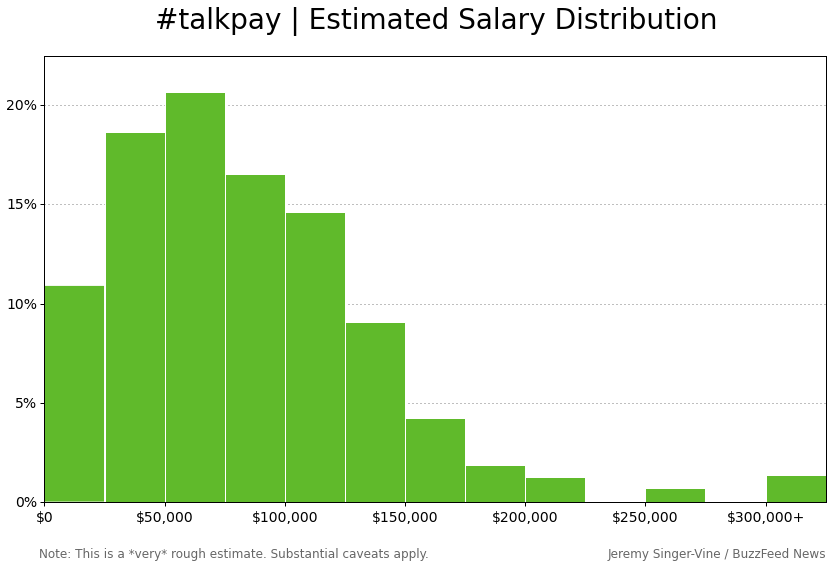

In [14]:
ax = make_chart(25 * 1000, 300 * 1000, 0.05)

---

---

---